In [1]:
import pandas as pd
import torch
import os 
from matplotlib import pyplot as plt
import matplotlib
import json
from Utilities import load_model
import logging

from ConvNetwork import ConvNet
from Tester import TestTools

import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim


C:\Users\20211575\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\20211575\Anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import numpy as np

In [3]:
def init_logging(log_file=None, append=False, console_loglevel=logging.INFO):
    """https://www.programcreek.com/python/example/136/logging.basicConfig"""
    """Set up logging to file and console."""
    if log_file is not None:
        if append:
            filemode_val = 'a'
        else:
            filemode_val = 'w'
        logging.basicConfig(level=logging.DEBUG,
                            format="%(asctime)s %(levelname)s %(threadName)s %(name)s %(message)s",
                            # datefmt='%m-%d %H:%M',
                            filename=log_file,
                            filemode=filemode_val)
    # define a Handler which writes INFO messages or higher to the sys.stderr
    console = logging.StreamHandler()
    console.setLevel(console_loglevel)
    # set a format which is simpler for console use
    formatter = logging.Formatter("%(message)s")
    console.setFormatter(formatter)
    # add the handler to the root logger
    logging.getLogger('').addHandler(console)
    global LOG
    LOG = logging.getLogger(__name__) 

In [4]:
init_logging()

# Load Pretrained Model

In [5]:
with open("./Config/output.json","r") as fin:
     output_conf=json.load(fin)

In [6]:
model=load_model(output_conf["path"]["model"],ConvNet,{"in_feature_2d":(28,28),"out_feature":10})

In [7]:
model.eval()

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (act1): ReLU()
  (pooling1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (act2): ReLU()
  (pooling2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (act3): ReLU()
  (pooling3): MaxPool2d(kernel_size=(7, 7), stride=(7, 7), padding=0, dilation=1, ceil_mode=False)
  (featureFC): Linear(in_features=32, out_features=2, bias=True)
  (outputFC): Linear(in_features=2, out_features=10, bias=True)
)

## Get data set

In [8]:
DEBUG=False
batch_size=None if DEBUG else 64
shuffle_flag=False if DEBUG else True
random_seed=1
if DEBUG:
    torch.manual_seed(random_seed)

train_data=torchvision.datasets.MNIST("./data",train=True,download=True,transform=torchvision.transforms.ToTensor())
test_data=torchvision.datasets.MNIST("./data",train=False,download=True,transform=torchvision.transforms.ToTensor())# Warning: ToTensor will divide the original data by 255
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=shuffle_flag,) 
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=shuffle_flag)

In [9]:
# TestTools.accuracy_rate(model,train_data.data/255,train_data.targets)

In [10]:

# TestTools.accuracy_rate(model,test_data.data/255,test_data.targets)

## Extract feature vectors

In [11]:
feature_gallery_path="./result/feature_gallery.csv"
if not os.path.exists(feature_gallery_path):
    feature_gallery=model.feature_extraction(train_data.data.reshape(-1,1,28,28)/255).detach().numpy()
    feature_gallery_df=pd.concat([pd.DataFrame(feature_gallery,columns=["x","y"]),pd.DataFrame(train_data.targets.numpy(),columns=["label"])],axis=1,join="inner")
    if DEBUG: print(feature_gallery_df.head())
    # persistance the feature gallery for further process
    feature_gallery_df.to_csv(feature_gallery_path,index=False)
else:
    feature_gallery_df=pd.read_csv(feature_gallery_path)

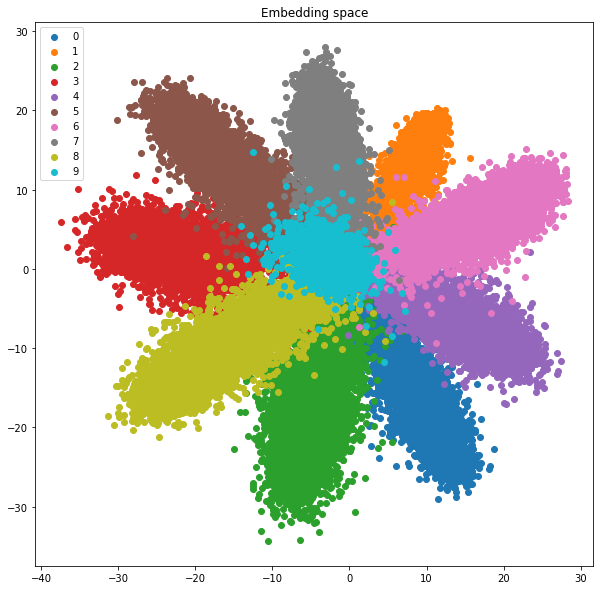

In [12]:
fig=plt.figure("Gallery Embedding space",figsize=(10,10))
ax=fig.subplots(1,1)
for key,data in feature_gallery_df.groupby("label"):
    ax.scatter(data["x"],data["y"],label=key)
ax.set_title("Embedding space")
ax.legend()

In [13]:
from Visualizers import VisualizationEmbeding

In [14]:
embeding_space_vis=VisualizationEmbeding(train_data,0)

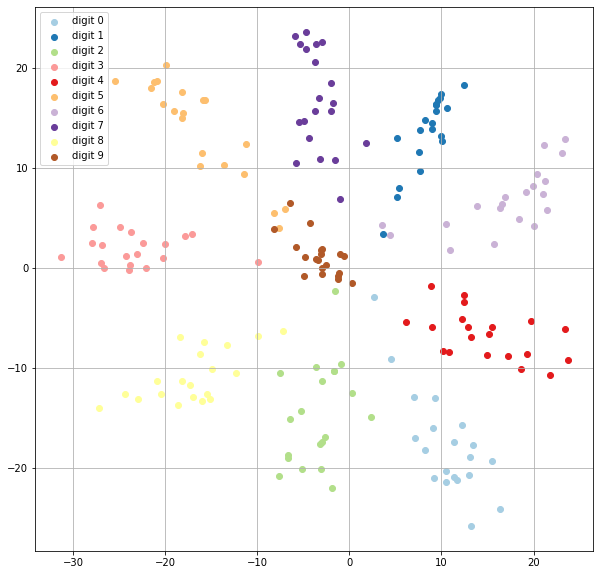

In [15]:
embeding_space_vis.sample_datas(20)
embeding_space_vis(model)

In [16]:
from Queryer import QueryReID

In [17]:
mnist_query=QueryReID(model,train_data.data.float().numpy()/255,train_data.targets.numpy(),gallery=feature_gallery_df)

In [18]:
mnist_query.get_query_feature(test_data.data[0].reshape(-1,1,28,28).float()/255)

array([[-4.766884, 20.874949]], dtype=float32)

In [39]:
idx=[0,1,2,3,4,5,6,156,8749,9845]
query_data=test_data.data[idx].reshape(-1,1,28,28).float()/255
query_target=test_data.targets[idx].numpy()
query_feature=mnist_query.get_query_feature(query_data)
top20=mnist_query.query(query_data,20)
# mnist_query.draw(top20,idx,query_data,query_target)

print(mnist_query.reid_accuracy_rate(test_data.data.reshape(-1,1,28,28)/255,test_data.targets,20,"mean"))

In [20]:
top20[0].mean()

31699.5

In [21]:
data_all,target_all=mnist_query.get_gallery_data(top20)
for i in range(top20.shape[0]):
    data,target=mnist_query.get_gallery_data(top20[i,:])
    print(np.all(target==target_all[i,:]))

True
True
True
True
True
True
True
True
True
True


In [22]:
query_target.reshape(-1,1)

array([[7],
       [2],
       [1],
       [0],
       [4],
       [1],
       [4],
       [6],
       [7],
       [1]], dtype=int64)

In [23]:
all_comp=target_all==query_target.reshape(-1,1)
for i in range(target_all.shape[0]):
    print( np.all(  all_comp[i]== (target_all[i,:]==query_target[i])  )  )

True
True
True
True
True
True
True
True
True
True


In [24]:
all_comp.shape

(10, 20)

In [25]:
all_comp.sum(axis=1)

array([20, 18, 20, 20, 20, 20, 20, 20, 20, 20])

In [26]:
query_data.shape

torch.Size([10, 1, 28, 28])

In [27]:
feature_temp=model.feature_extraction(train_data.data[:10].float().reshape(-1,1,28,28)/255).detach().numpy()

In [28]:
np.linalg.norm((feature_temp[i]-mnist_query.gallery[["x","y"]].to_numpy()),axis=1).shape

(60000,)

In [29]:
for i in range(10):
    print(np.allclose((np.linalg.norm((feature_temp-mnist_query.gallery[["x","y"]].to_numpy()[:,None]),axis=-1).T)[i],np.linalg.norm((feature_temp[i]-mnist_query.gallery[["x","y"]].to_numpy()),axis=1)))

True
True
True
True
True
True
True
True
True
True


In [30]:
k=1
np.argsort(np.linalg.norm((feature_temp-mnist_query.gallery[["x","y"]].to_numpy()[:,None]),axis=-1).T,axis=1)[:,:k]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]], dtype=int64)

In [31]:
print(feature_temp.shape)
print(mnist_query.gallery[["x","y"]].to_numpy()[:,None].shape)

(10, 2)
(60000, 1, 2)


In [32]:
feature_temp.shape

(10, 2)

In [33]:
(feature_temp-mnist_query.gallery[["x","y"]].to_numpy()[:5,None])[3][5]

array([-16.29713397, -36.28662901])

In [34]:
feature_temp[5]-mnist_query.gallery[["x","y"]].to_numpy()[3]

array([-16.29713397, -36.28662901])

In [35]:
for i in range(10):
    print(np.allclose((feature_temp[i,:]@mnist_query.gallery[["x","y"]].to_numpy().T),(feature_temp@mnist_query.gallery[["x","y"]].to_numpy().T)[i]))

True
True
True
True
True
True
True
True
True
True


In [36]:
np.argsort(feature_temp@mnist_query.gallery[["x","y"]].to_numpy().T)

array([[15525, 47937, 58225, ..., 18897, 47838, 25106],
       [18897, 29637, 48774, ..., 58489,  7728, 29395],
       [25106, 50935, 54780, ..., 15525, 47937, 58225],
       ...,
       [58225, 47937, 15525, ..., 47838, 50935, 25106],
       [21597, 59177, 20515, ...,  6732, 17126, 27943],
       [18897, 25106, 47838, ..., 58225, 47937, 15525]], dtype=int64)

In [37]:
feature_temp@mnist_query.gallery[["x","y"]].to_numpy()[15525]

array([-664.84511483,  696.33599145,  262.38545524,   41.03103483,
         -5.60647026,   82.23531581,   27.41233172, -663.49152854,
         36.8727497 ,  657.97293071])